In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Logic to be implemented in the next scraping, now I handle this with a try-if block
# reviews_df = reviews_df[dreviews_df['is_open']==1]

In [19]:
# Read the list of restaurants we sampled AND the list of their not-recommended reviews
italian_philly_df = pd.read_csv('outcomes/italian_philly.csv')
reviews_df = pd.read_csv('outcomes/not-recommended-reviews.csv')

In [20]:
# I join so I don't lose the business ID with 0 not-recommended reviews
# This would be the case if I directly group the reviews_df by business_id
joined_restaurant_reviews = italian_philly_df.merge(reviews_df, on='business_id', how='left')

In [21]:
# Group by "business_id" -> count (pd.size) -> transform the output (Series) to Dataframe by resetting the index.
review_counts = joined_restaurant_reviews.groupby('business_id').size().reset_index(name='not_recommended_count')

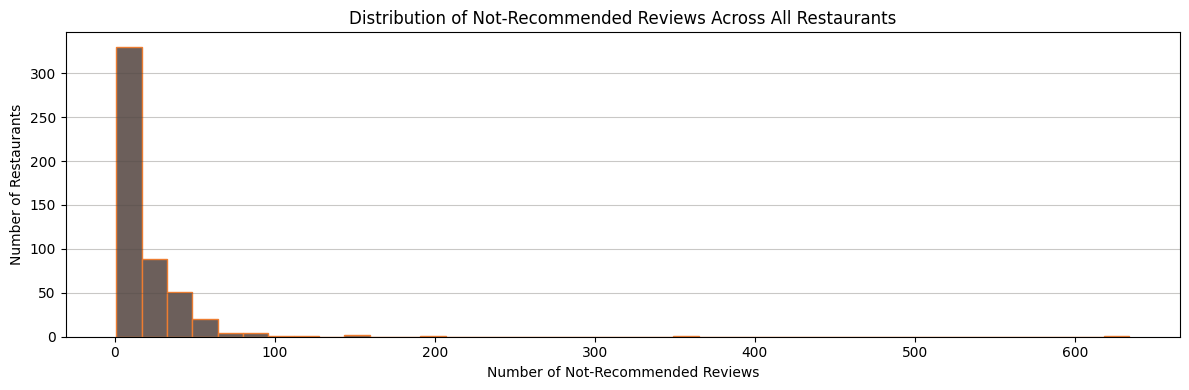

In [22]:
# Plotting a histogram for the distribution of the not-recommended reviews across all restaurants
plt.figure(figsize=(12, 4))
plt.hist(review_counts['not_recommended_count'], bins=40, color='#6C5F5B', edgecolor='#ED7D31')
plt.xlabel('Number of Not-Recommended Reviews')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Not-Recommended Reviews Across All Restaurants')
plt.grid(axis='y', alpha=0.3, color='#4F4A45')
plt.tight_layout()

In [23]:
# Calculate the 25th and 75th percentiles for not-recommended reviews
p25_threshold = review_counts['not_recommended_count'].quantile(0.25)
p75_threshold = review_counts['not_recommended_count'].quantile(0.75)

# Create two dataframe where we filter for n reviews < or > than the threshold above
# Having two datasets instead of one is easier for the 1:1 comparison. See later.
high_not_recommended = review_counts[review_counts['not_recommended_count'] > p75_threshold]
low_not_recommended = review_counts[review_counts['not_recommended_count'] < p25_threshold]

In [24]:
'''
#IF RUNNING FOR THE FIRST TIME TO EXTRACT NORMAL REVIEWS (NOT NEEDED IN THIS)
# Normal reviews
relevant_reviews = pd.DataFrame()

# the file is too big to be read at once, we need to read it in chunks
chunk_size = 100000 # this has to be adjusted, check this in case PC uni.
chunks = pd.read_json("yelp_dataset/reviews.json", lines=True, chunksize=chunk_size)

# select only those reviews whose business_ids are in the italian_philly.csv. 
for chunk in chunks:
    filtered_chunk = chunk[chunk['business_id'].isin(italian_philly_df["business_id"])]
    relevant_reviews = pd.concat([relevant_reviews, filtered_chunk], ignore_index=True)

relevant_reviews.to_csv("outcomes/relevant_reviews.csv", index=False)
'''

relevant_reviews = pd.read_csv('outcomes/relevant_reviews.csv')
relevant_reviews['date'] = pd.to_datetime(relevant_reviews['date'])


In [25]:
# just to check that all business_ids are included
unique_business_ids = relevant_reviews['business_id'].nunique()
print(f'there are {unique_business_ids} unique business_ids, for a total of {len(relevant_reviews)} reviews')

there are 505 unique business_ids, for a total of 82982 reviews


At this point we have:
- list of normal / not-recommended reviews
- count (p25 / p75)

Next: 
- extract the data of the first normal-reviews
- count the normal reviews

In [26]:
# Extrat the day of the first review for each restaurant
first_review_dates = relevant_reviews.groupby('business_id')['date'].min().reset_index()

# Calculate total review counts for each business
total_review_counts = relevant_reviews.groupby('business_id').size().reset_index(name='normal_reviews')

In [27]:
# Create the two final dataframe. They contain both the first review data and the number of normal reviews

# Adding the date of first review 
low_not_recommended_with_dates = low_not_recommended.merge(first_review_dates, on='business_id', how='left')
high_not_recommended_with_dates = high_not_recommended.merge(first_review_dates, on='business_id', how='left')

# Adding the number of normal reviews
low_not_recommended_final = low_not_recommended_with_dates.merge(total_review_counts, on='business_id', how='left')
high_not_recommended_final = high_not_recommended_with_dates.merge(total_review_counts, on='business_id', how='left')

In [28]:
#how the final dataframe look like
high_not_recommended_final.head(3)


,business_id,not_recommended_count,date,normal_reviews
0,-HxLFWKVgXSU8JlR21PBkg,32,2010-05-02 02:32:25,10
1,-UJ7ZTb3zfmqZogmy3fnGg,40,2006-10-15 17:37:52,325
2,-cEFKAznWmI0cledNOIQ7w,87,2014-12-27 15:47:00,1182


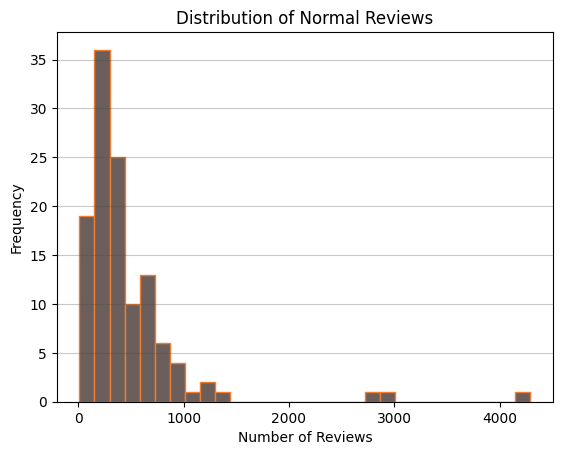

In [29]:
plt.hist(high_not_recommended_final['normal_reviews'], bins=30, color='#6C5F5B', edgecolor='#ED7D31')
plt.grid(axis='y', alpha=0.3, color='#4F4A45')
plt.title('Distribution of Normal Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

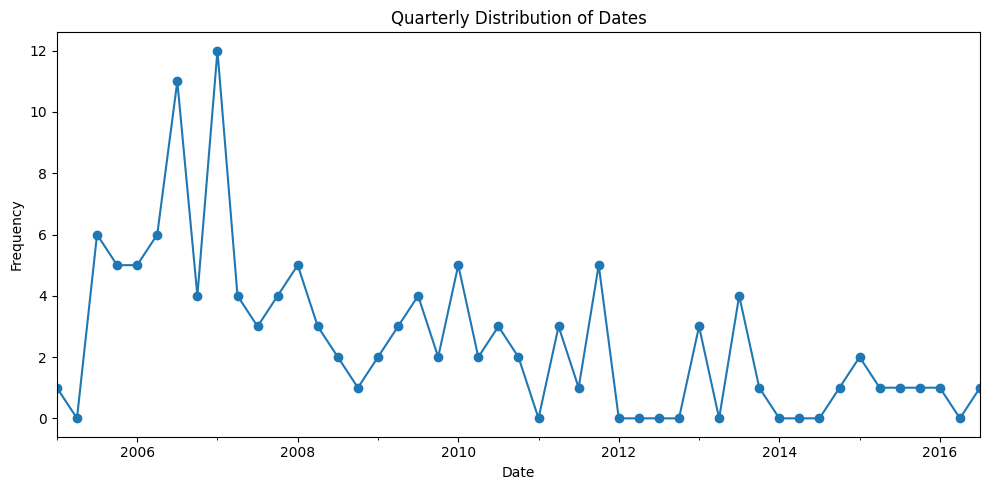

In [30]:
# Plotting distribution of dates
quarterly_counts = high_not_recommended_final.resample('Q', on='date').size()

# Plotting the quarterly distribution
plt.figure(figsize=(10, 5))
quarterly_counts.plot(kind='line', marker='o')
plt.title('Quarterly Distribution of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [36]:

# Matching the restaurants in the p75 group with those in the p25 group
# Based on: date of first review AND number of total reviews
matched_pairs_75_to_25 = []

# the list is created comparing every restaurant in the p75 with every restaurant in the p25
for _, high_row in high_not_recommended_final.iterrows():
    # I decided to use one year as delta due to the distribution showed in the grapth above ('Quarterly Distribution of Dates')
    # Using fewes day is of course possible, but the sample that results might be too small...
    start_date = high_row['date'] - timedelta(days=360)  
    end_date = high_row['date'] + timedelta(days=360)    
    
    # The number of reviews per restaurant is skewed to the right, the mayjority of restaurant are on the right and it's easy to find 
    # restaurants with a similar number of reviews.
    review_min = (1 - 0.40) * high_row['normal_reviews']
    review_max = (1 + 0.60) * high_row['normal_reviews']
    
    # Check for those restaurants, whose date and normal_reviews columns are in the ranged defined above.
    matches = low_not_recommended_final[
        (low_not_recommended_final['date'].between(start_date, end_date)) &
        (low_not_recommended_final['normal_reviews'].between(review_min, review_max))
    ]
    
    # save the pares in the list.
    # the set contains 2 resturants that were founded at the same time and have a similar number of reviews
    # one restaurant can be similar to one OR more restuarant
    for _, match_row in matches.iterrows():
        matched_pairs_75_to_25.append((high_row['business_id'], match_row['business_id']))

for pair in matched_pairs_75_to_25:
    (print(pair))

('-HxLFWKVgXSU8JlR21PBkg', '0BJy9The-xE_M912gkwDHQ')
('-HxLFWKVgXSU8JlR21PBkg', '7EIvsWIjK5EXhu-XURuTRA')
('-HxLFWKVgXSU8JlR21PBkg', 'GXSLrw48fYWpLJ__fxJgZA')
('-HxLFWKVgXSU8JlR21PBkg', 'JbKTtN9goxrWEvuGmE4FOQ')
('-HxLFWKVgXSU8JlR21PBkg', 'Xzpm5E8JeFW8QSfDowksMQ')
('-HxLFWKVgXSU8JlR21PBkg', 'dGy_GFVHQbmqzcIpSY6fSw')
('-HxLFWKVgXSU8JlR21PBkg', 'dIuZ9SDAkiFzg1yuA8RkeA')
('-HxLFWKVgXSU8JlR21PBkg', 'urXE9YSeQpOv16kjDu6CHg')
('-HxLFWKVgXSU8JlR21PBkg', 'wTZMIjj8RHMamUO1WzLTlQ')
('2qVZiMB22YPC2HCM62Gnbw', 'n5TNfoXg1i8wX5R3iY4WUA')
('N_zgKDHop40kPOq_9Uz0Fg', 'YBjFuFJXKBKdsxx2TlQVPw')
('VIYvcX9SScnqmoI0so1KZA', 'AqX_5srdyAS1tNiqC3mDvg')
('Yjl8zvY3uujvpbKMXWOpXQ', 'AU5C7IX0mogLK32u2EEOBQ')
('avB60OOVc_YOyfbz2AqL_g', 'AqX_5srdyAS1tNiqC3mDvg')
('fU_PgV2qca4dEo2ZPmivPA', 'YBjFuFJXKBKdsxx2TlQVPw')
('f_bUsM34FGpzECag3Cn8gw', '3966MAWoL1GbB8Zjvspx1g')
('f_bUsM34FGpzECag3Cn8gw', 'DjdSIwAbttOUQWa8gpWzTQ')
('f_bUsM34FGpzECag3Cn8gw', 'LlT0_n7AU4C-WBP-I5DkeA')
('f_bUsM34FGpzECag3Cn8gw', 'u4yZ_V4JA96c5xqJCJ